In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
import warnings
import scipy.signal as sig
import sys
# import seaborn as sns
# import gsw as gsw
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle
# import seawater as sw
import cmocean as cm
from dask.diagnostics import ProgressBar

warnings.filterwarnings("ignore")

In [9]:
import xesmf as xe
    
def regrid(var, lons, lats, which):
    # rename coords for use with xESMF
    lonkey = [coord for coord in var.coords if "nav_lon" in coord][0]
    latkey = [coord for coord in var.coords if "nav_lat" in coord][0]
    var = var.rename({lonkey: "lon", latkey: "lat"})

    # whether inputs are
    if which == "pairs":
        locstream_out = True
    elif which == "grid":
        locstream_out = False

    # set up for output
    varint = xr.Dataset({"lat": (["y", "x"], lats), "lon": (["y", "x"], lons)})

    # Calculate weights.
    regridder = xe.Regridder(var, varint, "bilinear",  locstream_out=locstream_out)

    # Perform interpolation
    varint = regridder(var, keep_attrs=True)
    return varint, regridder



In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [3]:
dxx=0.5

In [4]:
path='/data/pacific/lrenault/SASI/CROCO/FULL/'
listm=glob(path+'surf*.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[1:],data_vars='minimal')

path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[1:],data_vars='minimal')

In [5]:
chunks_new={'time_counter':40}

path='/data/pacific/lrenault/SASI/FULL/WRF/'
listmw=glob(path+'*DAY.nc');listmw.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varfw=xr.open_mfdataset(listmw[-7:],chunks=chunks_new)

path='/data/pacific/lrenault/SASI/SMTH/WRF/'
listtw=glob(path+'*DAY.nc');listtw.sort()
#vart=xr.open_dataset(listt[xmon])
vartw=xr.open_mfdataset(listtw[-7:],chunks=chunks_new)

In [6]:
import pandas as pd
timer=pd.DatetimeIndex(varf.time_counter.groupby("time_counter.dayofyear").mean())[:-1]

In [28]:
day=0

# Figure 2 - Methods - Coupling Schematic

### List of variables
Wind stress

In [14]:
lonx,latx=varf.temp.nav_lon_rho.compute()[1:-1,1:-1],varf.temp.nav_lat_rho.compute()[1:-1,1:-1]

In [27]:
tauxf=varf.sustr.groupby("time_counter.dayofyear").mean().compute()
tauyf=varf.svstr.groupby("time_counter.dayofyear").mean().compute()


In [29]:
tauxf=(0.5*(tauxf[:,:,1:]+tauxf[:,:,:-1]))[day,100:-100,100:-200][1:-1,:]
tauyf=(0.5*(tauyf[:,1:,:]+tauyf[:,:-1,:]))[day,100:-100,100:-200][:,1:-1]


Currents

In [84]:
uf=varf.u.groupby("time_counter.dayofyear").mean().compute()
vf=varf.v.groupby("time_counter.dayofyear").mean().compute()

In [87]:
ut=vart.u.groupby("time_counter.dayofyear").mean().compute()
vt=vart.v.groupby("time_counter.dayofyear").mean().compute()

In [85]:
uf=(0.5*(uf[:,:,1:]+uf[:,:,:-1]))[day,100:-100,100:-200][1:-1,:]
vf=(0.5*(vf[:,1:,:]+vf[:,:-1,:]))[day,100:-100,100:-200][:,1:-1]

In [88]:
ut=(0.5*(ut[:,:,1:]+ut[:,:,:-1]))[day,100:-100,100:-200][1:-1,:]
vt=(0.5*(vt[:,1:,:]+vt[:,:-1,:]))[day,100:-100,100:-200][:,1:-1]

Temperature and net heatflux

In [63]:
%%time
# chunks_new={'dayofyear':40}

tf=varf.temp.groupby("time_counter.dayofyear").mean()
# tf=tf.chunk(chunks=chunks_new);
tf=tf[:,100:-100,100:-200].compute();
tf=tf[day,1:-1,1:-1].compute()

tt=vart.temp.groupby("time_counter.dayofyear").mean()
# tt=tt.chunk(chunks=chunks_new);
tt=tt[:,100:-100,100:-200].compute();
tt=tt[day,1:-1,1:-1]

hf=varf.shflx.groupby("time_counter.dayofyear").mean()
# hf=hf.chunk(chunks=chunks_new);
hf=hf[:,100:-100,100:-200].compute();
hf=hf[day,1:-1,1:-1]

ht=vart.shflx.groupby("time_counter.dayofyear").mean()
# ht=ht.chunk(chunks=chunks_new);
ht=ht[:,100:-100,100:-200].compute();
ht=ht[day,1:-1,1:-1]

CPU times: user 1min 12s, sys: 21.7 s, total: 1min 34s
Wall time: 15.3 s


In [26]:
varfw

<xarray.Dataset>
Dimensions:               (y: 390, x: 300, lev_M: 49, lev_W: 50, time_counter: 213, axis_nbounds: 2)
Coordinates:
    nav_lat               (y, x) float32 dask.array<chunksize=(390, 300), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(390, 300), meta=np.ndarray>
  * lev_M                 (lev_M) float32 1.0 2.0 3.0 4.0 ... 47.0 48.0 49.0
  * lev_W                 (lev_W) float32 1.0 2.0 3.0 4.0 ... 48.0 49.0 50.0
    time_centered         (time_counter) datetime64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 2012-01-01T12:00:00 ....
Dimensions without coordinates: y, x, axis_nbounds
Data variables: (12/28)
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(31, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(31, 2), meta=np.ndarray>
    T2                    (time_counter, y, x) float32 dask.array<chunksize=(31, 390, 300), meta=np.ndarray>
    Q2                    (time_counter, y, x) float32 dask.array<chunksize=(31, 390, 300), meta=np.ndarray>
    RAINCV                (time_counter, y, x) float32 dask.array<chunksize=(31, 390, 300), meta=np.ndarray>
    RAINNCV               (time_counter, y, x) float32 dask.array<chunksize=(31, 390, 300), meta=np.ndarray>
    ...                    ...
    XKHH                  (time_counter, lev_M, y, x) float32 dask.array<chunksize=(31, 49, 390, 300), meta=np.ndarray>
    BN2                   (time_counter, lev_M, y, x) float32 dask.array<chunksize=(31, 49, 390, 300), meta=np.ndarray>
    AKMS                  (time_counter, y, x) float32 dask.array<chunksize=(31, 390, 300), meta=np.ndarray>
    AKHS                  (time_counter, y, x) float32 dask.array<chunksize=(31, 390, 300), meta=np.ndarray>
    EXCH_H                (time_counter, lev_W, y, x) float32 dask.array<chunksize=(31, 50, 390, 300), meta=np.ndarray>
    EXCH_M                (time_counter, lev_W, y, x) float32 dask.array<chunksize=(31, 50, 390, 300), meta=np.ndarray>
Attributes: (12/100)
    name:                            Out/wrf_3D_Y2012M01_DAY
    description:                     wrf M grid variables
    title:                           wrf M grid variables
    Conventions:                     CF-1.6
    timeStamp:                       2020-Jul-30 22:34:33 GMT
    uuid:                            42198aea-d8e9-4067-956c-4346ac67e533
    ...                              ...
    ISLAKE:                          -1
    ISICE:                           24
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

In [33]:
w_f=regrid(varfw.WSPD10,
                lons=varf.nav_lon_rho.data[100:-100,100:-200],
                lats=varf.nav_lat_rho.data[100:-100,100:-200],
                which='grid')[0][day][1:-1,1:-1]

sh_f=regrid(varfw.HFX,
                lons=varf.nav_lon_rho.data[100:-100,100:-200],
                lats=varf.nav_lat_rho.data[100:-100,100:-200],
                which='grid')[0][day][1:-1,1:-1]

lh_f=regrid(varfw.LH,
                lons=varf.nav_lon_rho.data[100:-100,100:-200],
                lats=varf.nav_lat_rho.data[100:-100,100:-200],
                which='grid')[0][day][1:-1,1:-1]

lw_f=regrid(varfw.GLW,
                lons=varf.nav_lon_rho.data[100:-100,100:-200],
                lats=varf.nav_lat_rho.data[100:-100,100:-200],
                which='grid')[0][day][1:-1,1:-1]
# sh_t=regrid(vartw.HFX,
#                 lons=varf.nav_lon_rho.data[100:-100,100:-200],
#                 lats=varf.nav_lat_rho.data[100:-100,100:-200],
#                 which='grid')[0][day][1:-1,1:-1]

# tw_f=regrid(varfw.SST,
#                 lons=varf.nav_lon_rho.data[100:-100,100:-200],
#                 lats=varf.nav_lat_rho.data[100:-100,100:-200],
#                 which='grid')[0][day][1:-1,1:-1]
tw_t=regrid(vartw.SST,
                lons=varf.nav_lon_rho.data[100:-100,100:-200],
                lats=varf.nav_lat_rho.data[100:-100,100:-200],
                which='grid')[0][day][1:-1,1:-1]

taw_f=regrid(varfw.T2,
                lons=varf.nav_lon_rho.data[100:-100,100:-200],
                lats=varf.nav_lat_rho.data[100:-100,100:-200],
                which='grid')[0][day][1:-1,1:-1]
# taw_t=regrid(vartw.T2,
#                 lons=varf.nav_lon_rho.data[100:-100,100:-200],
#                 lats=varf.nav_lat_rho.data[100:-100,100:-200],
#                 which='grid')[0][day][1:-1,1:-1]
prep_f=regrid(varfw.RAIN,
                lons=varf.nav_lon_rho.data[100:-100,100:-200],
                lats=varf.nav_lat_rho.data[100:-100,100:-200],
                which='grid')[0][0][1:-1,1:-1]


Overwrite existing file: bilinear_390x300_1320x700.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_390x300_1320x700.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_390x300_1320x700.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_390x300_1320x700.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_390x300_1320x700.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_390x300_1320x700.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_390x300_1320x700.nc 
 You can set reuse_weights=True to save computing time.


In [72]:
L=2257*1000 # Js/Kg
rho=1024
Evap_f=lh_f.data/(L*rho)# m/s   #*86400

In [73]:
EP_f=Evap_f-(prep_f.data/(86400*1000));

# WRF Parameters

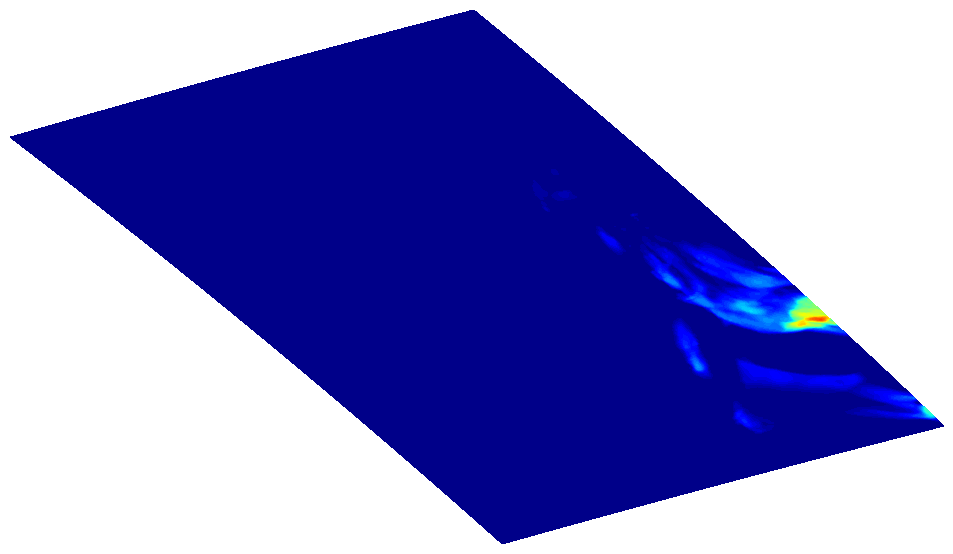

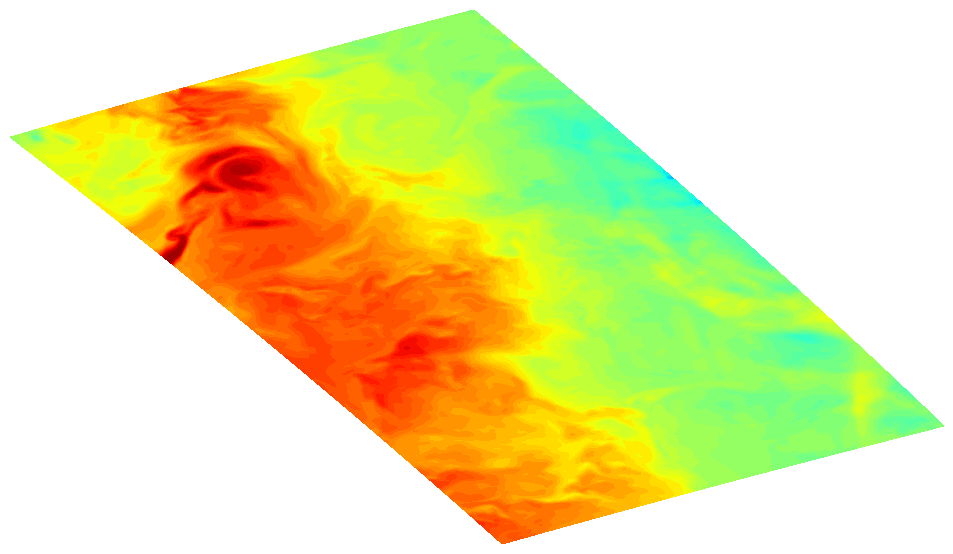

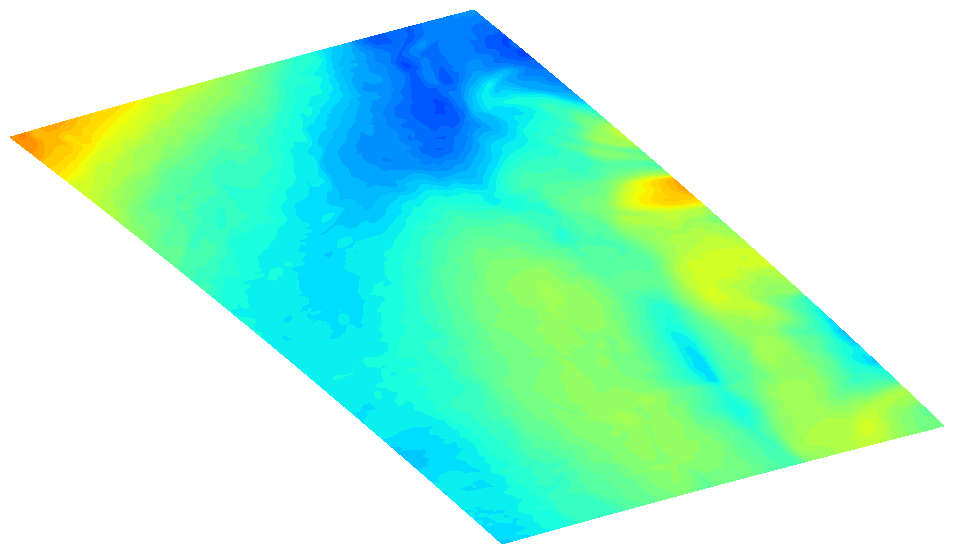

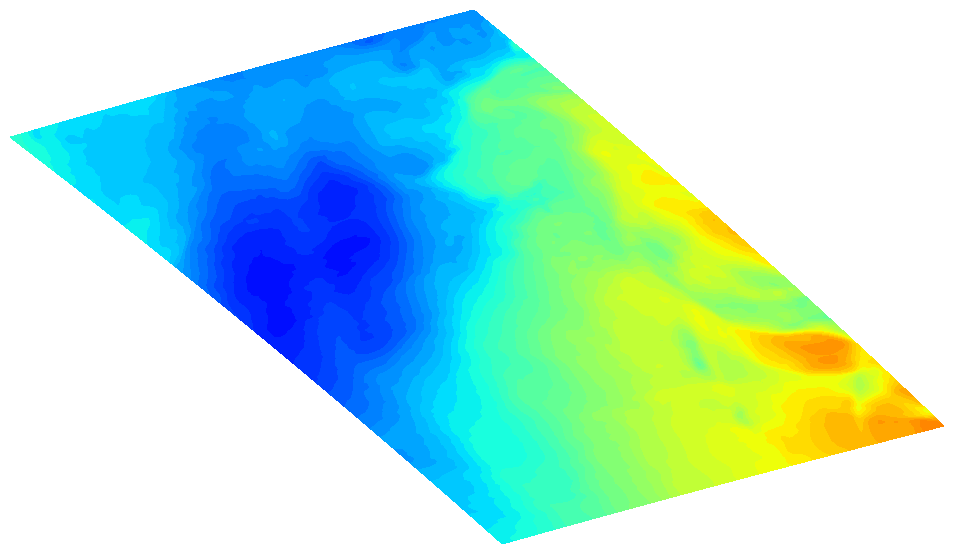

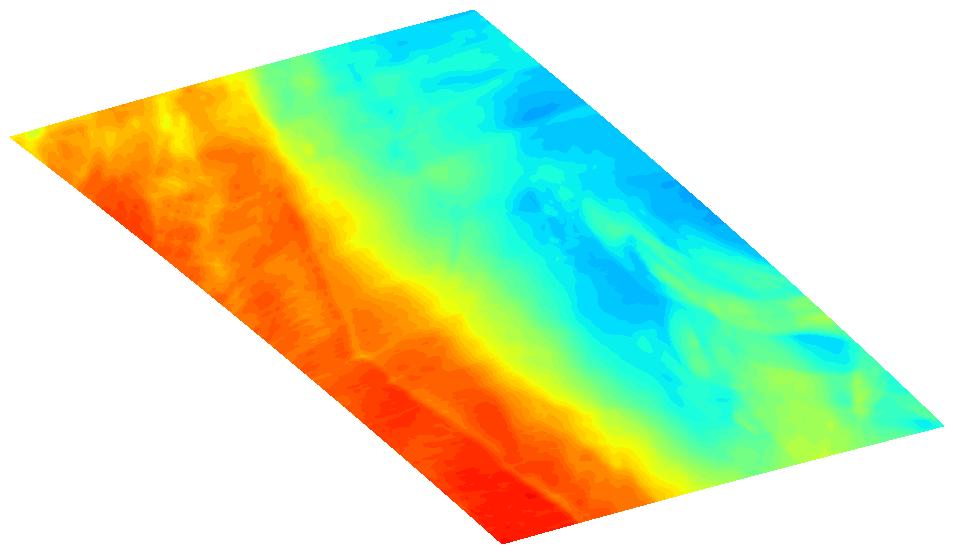

In [90]:
fig=plt.figure(figsize=(10,6))

# plt.subplot(4,2,1)
imm=plt.contourf(tf.nav_lon_rho,tf.nav_lat_rho,prep_f,levels=np.linspace(0,5e-5,55),cmap='jet')
# cb = plt.colorbar(imm,pad=0.04,ticks=np.arange(0,6e-5,1e-5))
# cb.set_label(label=r'mm', fontsize=20)
# cb.ax.tick_params(labelsize='large')

plt.xlabel('')
plt.ylabel('')
# plt.xticks(None,color='white')
# plt.yticks(None,color='white')
# ax = plt.axes()
# ax.spines['bottom'].set_color('white')
# plt.title(r'Precipitation',rotation=30,fontsize=20)


ax = plt.gca()  # gca stands for 'get current axis'
ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/poster/prep_FULL.png',dpi=300,transparent=True)


fig=plt.figure(figsize=(10,6))

# plt.subplot(4,2,1)
imm=plt.contourf(tf.nav_lon_rho,tf.nav_lat_rho,sh_f,levels=np.linspace(-25,25,55),cmap='jet')
# cb = plt.colorbar(imm,pad=0.04)
# cb.set_label(label=r'mm', fontsize=20)
# cb.ax.tick_params(labelsize='large')


plt.xlabel('')
plt.ylabel('')
# plt.xticks(None,color='white')
# plt.yticks(None,color='white')
# ax = plt.axes()
# ax.spines['bottom'].set_color('white')
plt.title(r'',fontsize=20)


ax = plt.gca()  # gca stands for 'get current axis'
ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/poster/SH_FULL.png',dpi=300,transparent=True)


fig=plt.figure(figsize=(10,6))

# plt.subplot(4,2,1)
imm=plt.contourf(tf.nav_lon_rho,tf.nav_lat_rho,w_f,levels=np.linspace(0,10,55),cmap='jet')
# cb = plt.colorbar(imm,pad=0.04)
# cb.set_label(label=r'mm', fontsize=20)
# cb.ax.tick_params(labelsize='large')


plt.xlabel('')
plt.ylabel('')
# plt.xticks(None,color='white')
# plt.yticks(None,color='white')
# ax = plt.axes()
# ax.spines['bottom'].set_color('white')
plt.title(r'',fontsize=20)


ax = plt.gca()  # gca stands for 'get current axis'
ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/poster/wind_FULL.png',dpi=300,transparent=True)


fig=plt.figure(figsize=(10,6))

# plt.subplot(4,2,1)
imm=plt.contourf(tf.nav_lon_rho,tf.nav_lat_rho,taw_f-273.15,levels=np.linspace(8,15,55),cmap='jet')
# cb = plt.colorbar(imm,pad=0.04)
# cb.set_label(label=r'mm', fontsize=20)
# cb.ax.tick_params(labelsize='large')


plt.xlabel('')
plt.ylabel('')
# plt.xticks(None,color='white')
# plt.yticks(None,color='white')
# ax = plt.axes()
# ax.spines['bottom'].set_color('white')
plt.title(r'',fontsize=20)


ax = plt.gca()  # gca stands for 'get current axis'
ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/poster/nc_T_Air_FULL.png',dpi=300,transparent=True)


fig=plt.figure(figsize=(10,6))

# plt.subplot(4,2,1)
imm=plt.contourf(tf.nav_lon_rho,tf.nav_lat_rho,lw_f,levels=np.linspace(230,370,55),cmap='jet')
# cb = plt.colorbar(imm,pad=0.04)
# cb.set_label(label=r'mm', fontsize=20)
# cb.ax.tick_params(labelsize='large')


plt.xlabel('')
plt.ylabel('')
# plt.xticks(None,color='white')
# plt.yticks(None,color='white')
# ax = plt.axes()
# ax.spines['bottom'].set_color('white')
plt.title(r'',fontsize=20)


ax = plt.gca()  # gca stands for 'get current axis'
ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/poster/nc_GLW_FULL.png',dpi=300,transparent=True)




# OASIS parameters

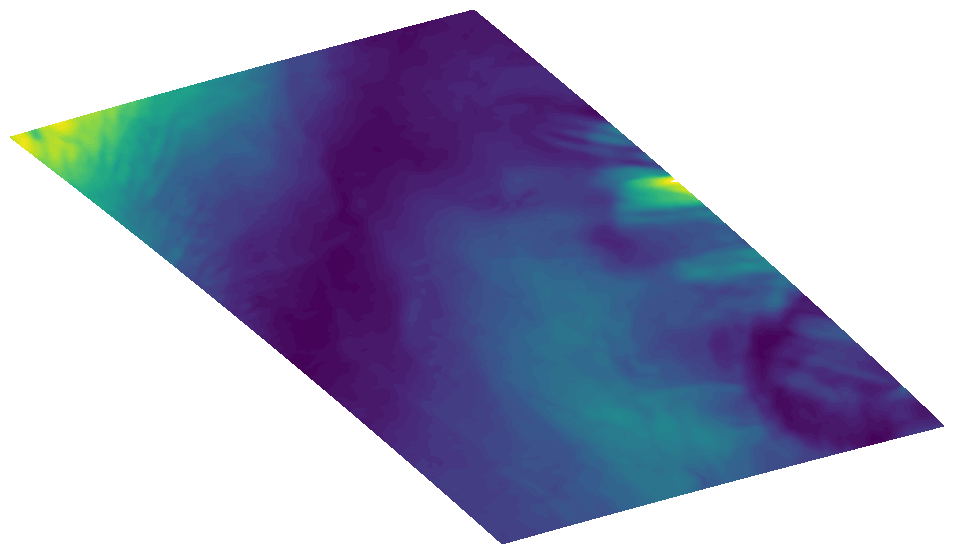

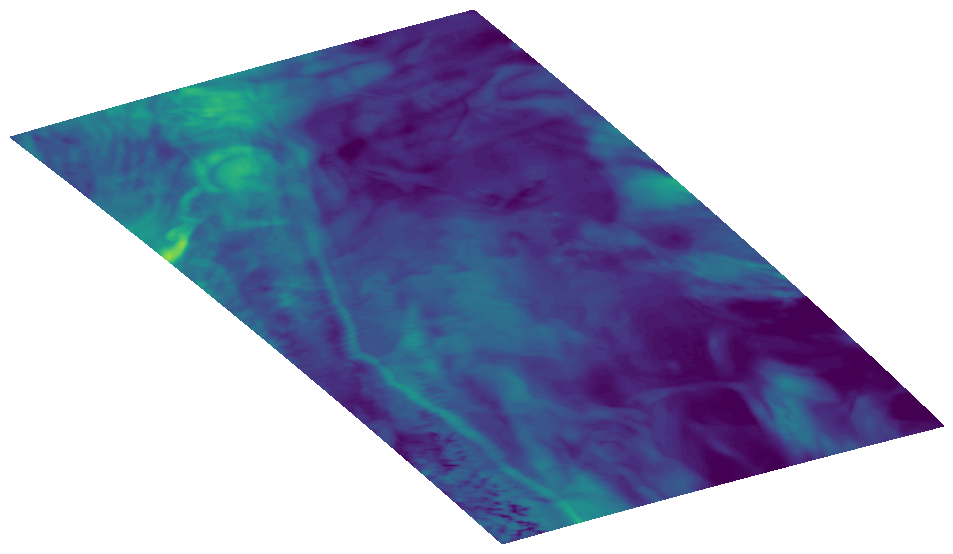

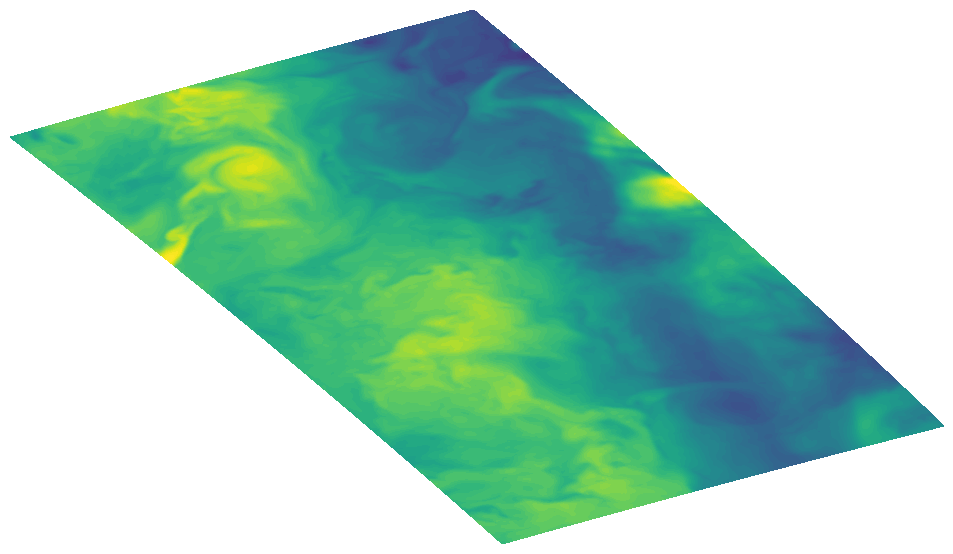

In [92]:
fig=plt.figure(figsize=(10,6))

# plt.subplot(4,2,1)
imm=plt.contourf(tf.nav_lon_rho,tf.nav_lat_rho,np.sqrt(tauxf.data**2 + tauyf.data**2),levels=np.linspace(0,0.1,55))
# cb = plt.colorbar(imm,pad=0.04)
# cb.set_label(label=r'mm', fontsize=20)
# cb.ax.tick_params(labelsize='large')


plt.xlabel('')
plt.ylabel('')
# plt.xticks(None,color='white')
# plt.yticks(None,color='white')
# ax = plt.axes()
# ax.spines['bottom'].set_color('white')
plt.title(r'',fontsize=20)


ax = plt.gca()  # gca stands for 'get current axis'
ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/poster/stress_FULL.png',dpi=300,transparent=True)




fig=plt.figure(figsize=(10,6))

# plt.subplot(4,2,1)
imm=plt.contourf(tf.nav_lon_rho,tf.nav_lat_rho,-hf,levels=np.linspace(0,150,55),extend='both')
# cb = plt.colorbar(imm,pad=0.04)
# cb.set_label(label=r'mm', fontsize=20)
# cb.ax.tick_params(labelsize='large')


plt.xlabel('')
plt.ylabel('')
# plt.xticks(None,color='white')
# plt.yticks(None,color='white')
# ax = plt.axes()
# ax.spines['bottom'].set_color('white')
plt.title(r'',fontsize=20)


ax = plt.gca()  # gca stands for 'get current axis'
ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/poster/Q_net_FULL.png',dpi=300,transparent=True)



fig=plt.figure(figsize=(10,6))

# plt.subplot(4,2,1)
imm=plt.contourf(tf.nav_lon_rho,tf.nav_lat_rho,EP_f,levels=np.linspace(0,3.2e-8,55),extend='both')
# cb = plt.colorbar(imm,pad=0.04)
# cb.set_label(label=r'mm', fontsize=20)
# cb.ax.tick_params(labelsize='large')


plt.xlabel('')
plt.ylabel('')
# plt.xticks(None,color='white')
# plt.yticks(None,color='white')
# ax = plt.axes()
# ax.spines['bottom'].set_color('white')
plt.title(r'',fontsize=20)


ax = plt.gca()  # gca stands for 'get current axis'
ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/poster/E-P_FULL.png',dpi=300,transparent=True)




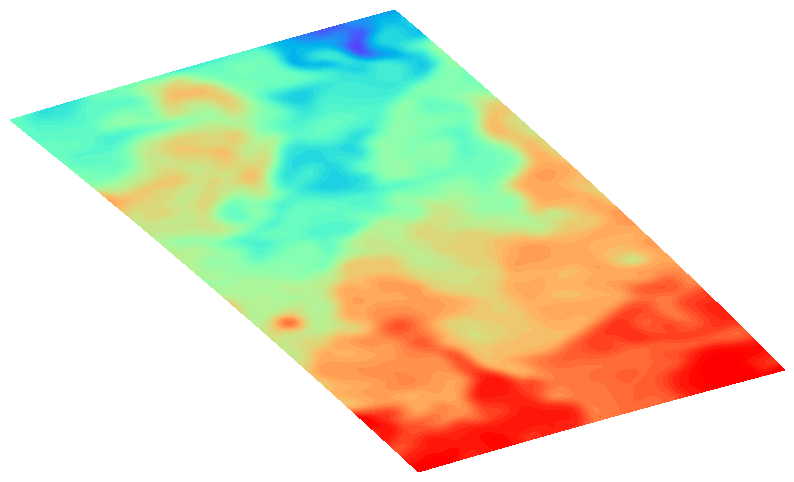

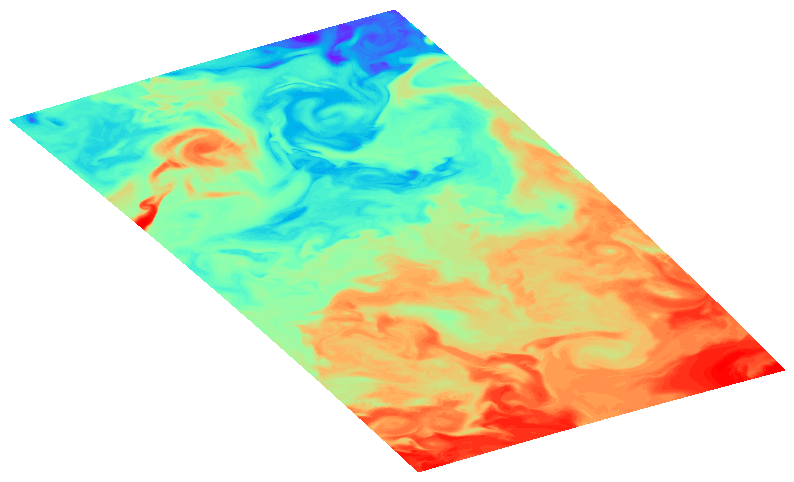

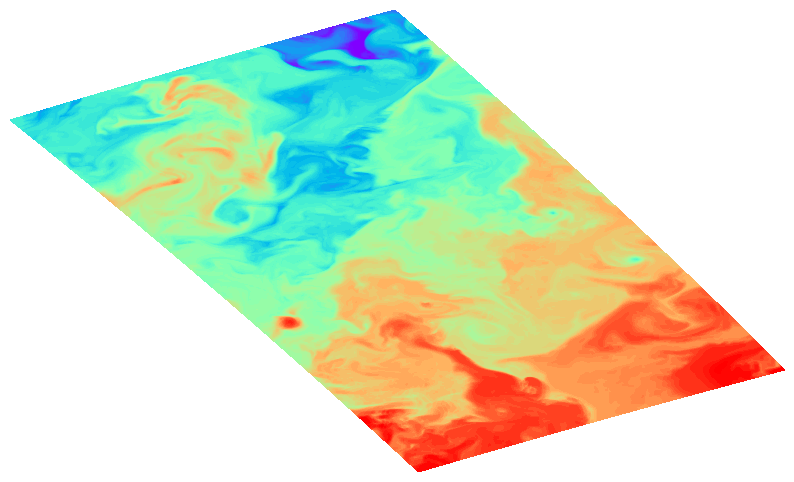

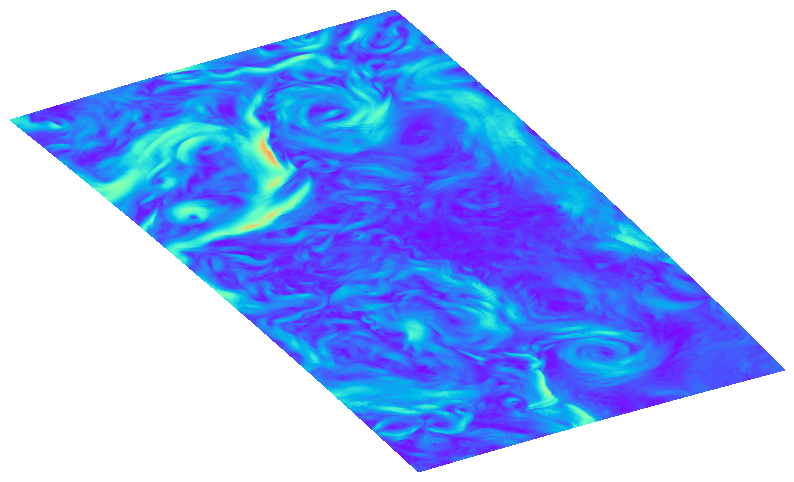

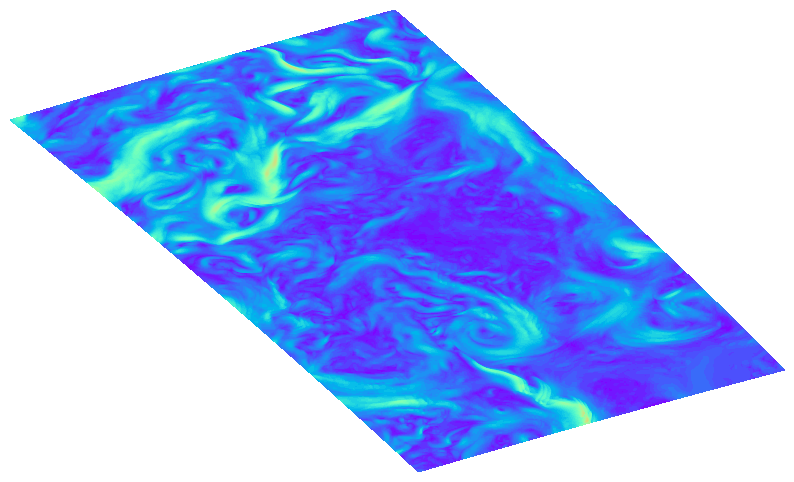

In [93]:



plt.figure(figsize=(10,6))
# plt.subplot(4,2,6)
plt.contourf(tf.nav_lon_rho,tf.nav_lat_rho,tw_t-273.15,levels=np.linspace(9.5,13,55),cmap='rainbow',extend='both')
# cb = plt.colorbar(imm,pad=0.04)
# cb.set_label(label=r'mm', fontsize=20)
# cb.ax.tick_params(labelsize='large')


plt.xlabel('')
plt.ylabel('')
# plt.xticks(None,color='white')
# plt.yticks(None,color='white')
# ax = plt.axes()
# ax.spines['bottom'].set_color('white')
plt.title(r'',fontsize=20)


ax = plt.gca()  # gca stands for 'get current axis'
ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
plt.savefig('/homes/metogra/iufarias/Documents/figures/poster/ncSST_WRF_SMTH.png',dpi=300,transparent=True)






plt.figure(figsize=(10,6))


# plt.subplot(4,2,7)
plt.contourf(tf.nav_lon_rho,tf.nav_lat_rho,tf,levels=np.linspace(9.5,13,55),cmap='rainbow',extend='both')

# cb = plt.colorbar(imm,pad=0.04)
# cb.set_label(label=r'mm', fontsize=20)
# cb.ax.tick_params(labelsize='large')


plt.xlabel('')
plt.ylabel('')
# plt.xticks(None,color='white')
# plt.yticks(None,color='white')
# ax = plt.axes()
# ax.spines['bottom'].set_color('white')
plt.title(r'',fontsize=20)


ax = plt.gca()  # gca stands for 'get current axis'
ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
plt.savefig('/homes/metogra/iufarias/Documents/figures/poster/ncSST_FULL.png',dpi=300,transparent=True)





# plt.subplot(4,2,8)
plt.figure(figsize=(10,6))

plt.contourf(tf.nav_lon_rho,tf.nav_lat_rho,tt,levels=np.linspace(9.5,13,55),cmap='rainbow',extend='both')

# cb = plt.colorbar(imm,pad=0.04)
# cb.set_label(label=r'mm', fontsize=20)
# cb.ax.tick_params(labelsize='large')


plt.xlabel('')
plt.ylabel('')
# plt.xticks(None,color='white')
# plt.yticks(None,color='white')
# ax = plt.axes()
# ax.spines['bottom'].set_color('white')
plt.title(r'',fontsize=20)


ax = plt.gca()  # gca stands for 'get current axis'
ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
plt.savefig('/homes/metogra/iufarias/Documents/figures/poster/ncSST_SMTH.png',dpi=300,transparent=True)






plt.figure(figsize=(10,6))
# plt.subplot(4,2,6)
plt.contourf(tf.nav_lon_rho,tf.nav_lat_rho,np.sqrt(uf.data**2 +vf.data**2),levels=np.linspace(0,1,55),cmap='rainbow',extend='both')
# cb = plt.colorbar(imm,pad=0.04)
# cb.set_label(label=r'mm', fontsize=20)
# cb.ax.tick_params(labelsize='large')


plt.xlabel('')
plt.ylabel('')
# plt.xticks(None,color='white')
# plt.yticks(None,color='white')
# ax = plt.axes()
# ax.spines['bottom'].set_color('white')
plt.title(r'',fontsize=20)


ax = plt.gca()  # gca stands for 'get current axis'
ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
plt.savefig('/homes/metogra/iufarias/Documents/figures/poster/ncSST_current_FULL.png',dpi=300,transparent=True)




plt.figure(figsize=(10,6))
# plt.subplot(4,2,6)
plt.contourf(tf.nav_lon_rho,tf.nav_lat_rho,np.sqrt(ut.data**2 +vt.data**2),levels=np.linspace(0,1,55),cmap='rainbow',extend='both')
# cb = plt.colorbar(imm,pad=0.04)
# cb.set_label(label=r'mm', fontsize=20)
# cb.ax.tick_params(labelsize='large')


plt.xlabel('')
plt.ylabel('')
# plt.xticks(None,color='white')
# plt.yticks(None,color='white')
# ax = plt.axes()
# ax.spines['bottom'].set_color('white')
plt.title(r'',fontsize=20)


ax = plt.gca()  # gca stands for 'get current axis'
ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
plt.savefig('/homes/metogra/iufarias/Documents/figures/poster/ncSST_current_SMTH.png',dpi=300,transparent=True)


